In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from scipy.signal import find_peaks
from functools import partial

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [8]:
def compute_average_waveform(files, bs_t_window=(-1.5e-5, -1.0e-5), threshold_bs=0.05):
    w = wfm2read(files[0], verbose=False)
    t, V = w[1], -w[0]

    V_avg = np.zeros_like(V)

    for f in files:
        t, V = load_waveform(f)

        # 1) Reject on "too large signal in baseline window"
        baseline_mask = (t > bs_t_window[0]) & (t < bs_t_window[1])
        V_w = V[baseline_mask]
        if (V_w > threshold_bs).sum() > 5:
            continue
        
        if V.shape != V_avg.shape:
            print(f'Warning: waveform in {f} has different shape. Skipping.')
            continue
        V_avg += V
    V_avg /= len(files)
    return V_avg, t

def compute_drift_time(t, V, height_S1=0.001):
    
    indS1 = find_peaks(V[t < 0], height=height_S1, distance=200)[0]

    if len(indS1) > 1:
        indS1 = indS1[np.argmax(V[indS1])]
    else:
        indS1 = indS1[0]

    indS2 = find_peaks(V[t > 0], height=V[indS1], distance=500)[0]

    if len(indS2) > 1:
        indS2 = indS2[np.argmin(t[indS2])]
    else:
        indS2 = indS2[0]
    indS2 += len(V[t < 0])
    return t[indS2] - t[indS1], indS1, indS2

def extract_voltage_pairs(base_dir, pattern=None):
    """Extract (anode_voltage, gate_voltage) pairs from subdirectory names."""
    voltage_pairs = []
    if pattern is None:
        pattern = 'FieldScan_1GSsec_Anode{}_Gate{}'
    subdirs = sorted(os.listdir(base_dir))
    for subdir in subdirs:
        try:
            gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
            anode_voltage = int(re.search(r'Anode(\d+)', subdir).group(1))
            # print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
            voltage_pairs.append((anode_voltage, gate_voltage))
        except AttributeError:
            continue
    return np.array(voltage_pairs)

In [3]:
def compute_average_drift_time(subdir, batch_size=20, pattern='*.wfm'):
    allFiles = sorted(glob(subdir+pattern))
    files_batch = [sorted(glob(subdir+pattern))[batch_size*i:batch_size*(i+1)] for i in range(len(allFiles)//batch_size)]
    t_drifts = []
    t_s1s = []
    t_s2s = []
    duration_s2s = []
    for i,fi in enumerate(files_batch):
        v_avg, t_avg = compute_average_waveform(fi)
        try:
            v_avg = subtract_baseline(t_avg, v_avg, (-1.5e-5, -1.0e-5))
        except ValueError:
            continue
        try:
            tdrift, indS1, indS2 = compute_drift_time(t_avg, v_avg)
            dur_s2, _ = compute_s2_duration(t_avg, v_avg, indS1, indS2, frac_s1=0.8, min_distance=50, max_distance=4000)
        except IndexError:
            print(f'No S1 or S2 found in file set {i}')
            continue
        t_drifts.append(tdrift)
        t_s1s.append(t_avg[indS1])
        t_s2s.append(t_avg[indS2])
        duration_s2s.append(dur_s2)

    t_s1s = np.array(t_s1s) * 1e6
    t_s2s = np.array(t_s2s) * 1e6
    t_drift_avg = np.average(t_s2s) - np.average(t_s1s)
    t_drift_std = np.sqrt(np.std(t_s1s)**2 + np.std(t_s2s)**2)
    duration_avg = np.average(duration_s2s) * 1e6
    duration_std = np.std(duration_s2s) * 1e6
    return (t_drift_avg, t_drift_std), (duration_avg, duration_std), np.average(t_s1s), np.average(t_s2s)

def compute_s2_duration(t, V, indS1, indS2, frac_s1=0.8, min_distance=50, max_distance=4000):
    indS2_end = find_peaks(V[t > 0], height=V[indS1]*frac_s1, distance=min_distance)[0] + len(V[t < 0])
    indS2_end = indS2_end[np.where(np.diff(indS2_end) < max_distance)[0]]
    indS2_end = indS2_end[-1]
    tS2 = t[indS2_end] - t[indS2]
    return tS2, indS2_end

In [9]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/'
voltage_pairs = extract_voltage_pairs(base_dir, pattern='FieldScan_5GSsec_Anode{}_Gate{}')
anode_voltages = voltage_pairs[:,0]
gate_voltages = voltage_pairs[:,1]
field_el = (anode_voltages - gate_voltages) / 0.8  # V/cm
field_drift = gate_voltages / 1.4  # V/cm
field_drift

array([  35.71428571,   71.42857143,  142.85714286,  428.57142857,
        785.71428571, 1142.85714286, 1500.        ])

In [10]:
N=4.91e19  #cm-3 for 2.0 bar at 300 K
red_field_drift = field_drift/ N * 1e17 # Td
for f, rd in zip(field_drift, red_field_drift):
    print(f'{f:.2f} V/cm  -> {rd:.2f} Td')

35.71 V/cm  -> 0.07 Td
71.43 V/cm  -> 0.15 Td
142.86 V/cm  -> 0.29 Td
428.57 V/cm  -> 0.87 Td
785.71 V/cm  -> 1.60 Td
1142.86 V/cm  -> 2.33 Td
1500.00 V/cm  -> 3.05 Td


[Text(0.5, 0, 'Reduced field (Td)'), Text(0, 0.5, 'Drift velocity (mm/μs)')]

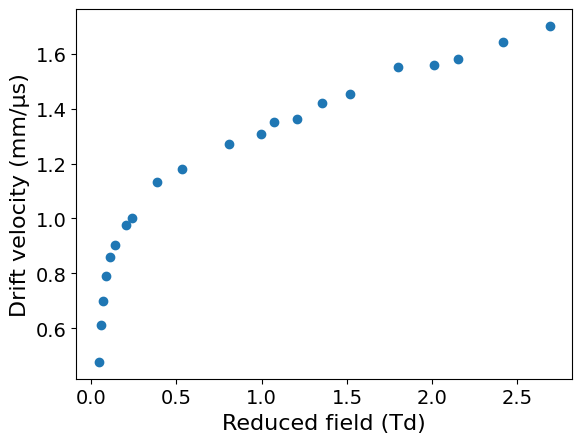

In [11]:
path_ds_graph = '/Users/pabloherrero/sabat/RaTagging/scope_data/driftSpeed_redField_data.csv'
ds_graph = pd.read_csv(path_ds_graph, names=['reduced_field_Td', 'drift_velocity_mm_per_us'])
plt.plot(ds_graph['reduced_field_Td'], ds_graph['drift_velocity_mm_per_us'], 'o', label='Data from graph')
plt.gca().set(xlabel='Reduced field (Td)', ylabel='Drift velocity (mm/μs)')

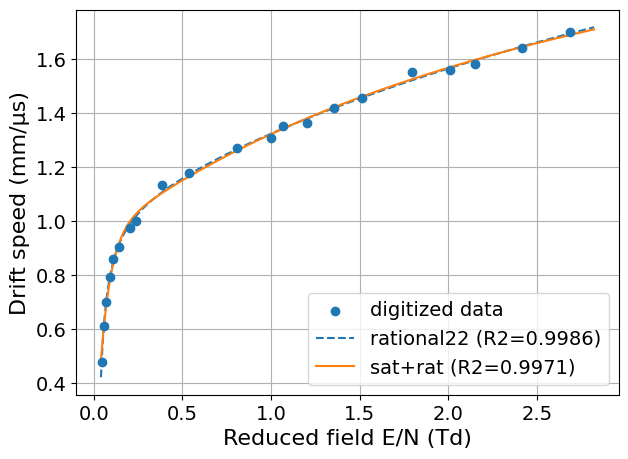

Rational 2/2 params: [ -66026.87926332 2668536.00773142 1350730.36200155 2563260.4929226
  424235.66676176]
Sat+Rational params: [ 0.92809704 17.17333489  0.51193002  0.30107278]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# --- Load your digitized data here (replace with your filename) ---
# Expect two columns: E (Td), v (mm/µs)
# data = np.loadtxt('digitized_points.csv', delimiter=',', skiprows=1)
# E = data[:,0]; v = data[:,1]

# for demo, replace with your actual digitized arrays:
rE = ds_graph['reduced_field_Td'].to_numpy()  # Td (example)
v = ds_graph['drift_velocity_mm_per_us'].to_numpy() # mm/µs (example)

# --- Model 1: Rational 2/2 ---
def rational22(E, a0, a1, a2, b1, b2):
    return (a0 + a1*E + a2*E**2) / (1.0 + b1*E + b2*E**2)

p0_r22 = [0.0, 1.0, 0.0, 1.0, 0.1]   # initial guesses
bounds_r22 = ([-np.inf,-np.inf,-np.inf, 0.0, 0.0], np.inf)  # ensure denominator positive coefficients non-negative
popt_r22, pcov_r22 = curve_fit(rational22, rE, v, p0=p0_r22, bounds=bounds_r22, maxfev=10000)
v_r22 = rational22(rE, *popt_r22)
r2_r22 = r2_score(v, v_r22)

# --- Model 2: saturating + rational tail ---
def sat_plus_rational(E, p0, p1, p2, p3):
    return p0*(1.0 - np.exp(-p1*E)) + (p2*E) / (1.0 + p3*E)

# popt_s = [ 0.92809704, 17.17333489,  0.51193002,  0.30107278]
p0_s = [1.0, 3.0, 0.5, 1.0]
bounds_s = (0.0, np.inf)  # all positive params
popt_s, pcov_s = curve_fit(sat_plus_rational, rE, v, p0=p0_s, bounds=bounds_s, maxfev=10000)
v_s = sat_plus_rational(rE, *popt_s)
r2_s = r2_score(v, v_s)

# --- Plot ---
E_plot = np.linspace(min(rE)*0.9, max(rE)*1.05, 300)
plt.figure(figsize=(7,5))
plt.scatter(rE, v, label='digitized data', zorder=5)
plt.plot(E_plot, rational22(E_plot, *popt_r22), '--', label=f'rational22 (R2={r2_r22:.4f})')
plt.plot(E_plot, sat_plus_rational(E_plot, *popt_s), '-', label=f'sat+rat (R2={r2_s:.4f})')
plt.xlabel('Reduced field E/N (Td)')
plt.ylabel('Drift speed (mm/µs)')
plt.legend()
plt.grid(True)
plt.show()

# --- Print parameters ---
print("Rational 2/2 params:", popt_r22)
print("Sat+Rational params:", popt_s)


In [17]:
def transport_saturation(E, p0, p1, p2, p3):
    return p0*(1.0 - np.exp(-p1*E)) + (p2*E) / (1.0 + p3*E)

popt_s = [ 0.92809704, 17.17333489,  0.51193002,  0.30107278]
field2drift = lambda E: transport_saturation(E, *popt_s)
drift_speeds = np.array([field2drift(Ei) for Ei in red_field_drift])
drift_times = 14 / drift_speeds  # µs

print(f'{"Red field (Td)":>15}, {"Drift speed (mm/µs)":>20}, {"Drift time (µs)":>15}')
for rf, ds, dt in zip(red_field_drift, drift_speeds, drift_times):
    print(f'{rf:15.2f}, {ds:20.4f}, {dt:15.4f}')

 Red field (Td),  Drift speed (mm/µs), Drift time (µs)
           0.07,               0.6984,         20.0457
           0.15,               0.9231,         15.1657
           0.29,               1.0588,         13.2229
           0.87,               1.2819,         10.9209
           1.60,               1.4809,          9.4534
           2.33,               1.6287,          8.5958
           3.05,               1.7427,          8.0333


In [20]:
field2drift(red_field_drift[0]), field_drift[0], red_field_drift[0]

(np.float64(0.6984057770018046),
 np.float64(35.714285714285715),
 np.float64(0.07273785277858598))

In [19]:
field_drift[2], red_field_drift[2], drift_speeds[2], drift_times[2]
print(f'Gate voltage: {gate_voltages[2]:.2f} V')
print(f'Field drift: {field_drift[2]:.2f} V/cm, Reduced field: {red_field_drift[2]:.2f} Td')
print(f'Drift speed: {drift_speeds[2]:.2f} mm/μs, Drift time: {drift_times[2]:.2f} μs')

Gate voltage: 200.00 V
Field drift: 142.86 V/cm, Reduced field: 0.29 Td
Drift speed: 1.06 mm/μs, Drift time: 13.22 μs


# Waveform rejection

In [77]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN2_EL3kVcm_1GSsec/'
voltage_pairs = extract_voltage_pairs(base_dir, pattern='FieldScan_1GSsec_EL{}_Gate{}')
anode_voltages = voltage_pairs[:,0]
gate_voltages = voltage_pairs[:,1]
field_el = (anode_voltages - gate_voltages) / 0.8  # V/cm
field_drift = gate_voltages / 1.4  # V/cm
red_field_drift

array([0.07273785, 0.08728542, 0.10183299, 0.11638056, 0.13092814,
       0.14547571, 0.21821356, 0.29095141, 0.36368926, 0.43642712,
       0.50916497, 0.58190282, 0.65464068, 0.72737853, 0.87285423])

In [79]:
field_drift[2], red_field_drift[2]

(np.float64(50.0), np.float64(0.10183299389002036))

In [205]:
subdirs = sorted(glob(base_dir+'/FieldScan*'))
files05 = sorted(glob(base_dir+'/FieldScan_5GSsec_Anode1950V_Gate50V/*.wfm'))
files2100 = sorted(glob(base_dir+'FieldScan_5GSsec_Anode4000V_Gate2100V/*.wfm'))
files2100[:10], subdirs

(['/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_26052025_Gate2100_Anode4000_P1_10000Wfm_Ch1.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_26052025_Gate2100_Anode4000_P1_10001Wfm_Ch1.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_26052025_Gate2100_Anode4000_P1_10002Wfm_Ch1.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_26052025_Gate2100_Anode4000_P1_10003Wfm_Ch1.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_26052025_Gate2100_Anode4000_P1_10004Wfm_Ch1.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/RUN5_

In [29]:
win = S2Window(subdirs[0], batch_size=50)
win.compute_average_s2_window()

(np.float64(-3.196037305699481e-06),
 np.float64(7.348841450777204e-06),
 np.float64(3.074113886010363e-05),
 np.float64(2.3392297409326423e-05))

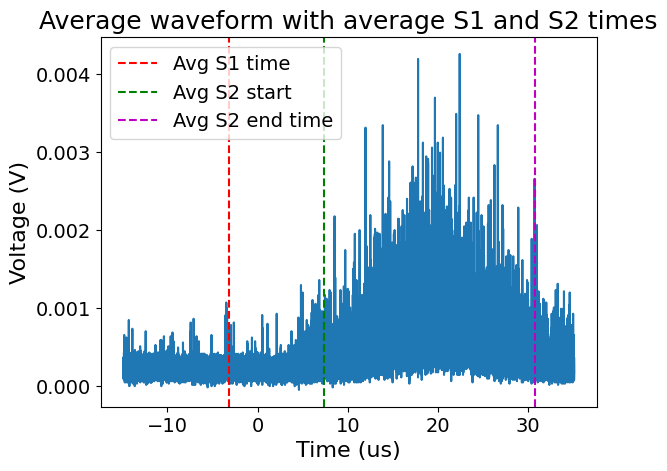

In [30]:
win.plot_avg_values()

In [35]:
win.s1_avg, win.duration

(np.float64(-3.196037305699481e-06), np.float64(2.3392297409326423e-05))

In [130]:
i = 1
xray = 0

In [152]:
drift_times[6]

np.float64(8.033301862437394)

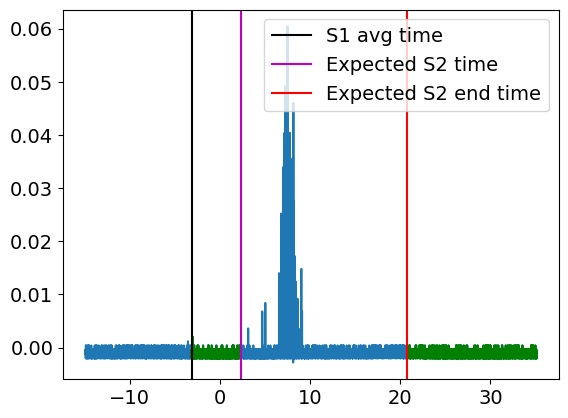

In [216]:
s1_jitter = 0.05 # μs
s2_tol_start = 2.5 # μs
# s2_duration = 8 # μs
s2_duration = 16
s2_tol_end = 2.5 # μs
# s2_tol_end = 10e-6
drift_window = (win.s1_avg * 1e6 + s1_jitter, win.s1_avg *1e6 - s1_jitter + drift_times[6] - s2_tol_start)
s2_window = (drift_window[1], drift_window[1] + s2_duration + s2_tol_end)

i += 1
file = files2100[i]
t, V = load_waveform(file)
t *= 1e6  # to μs

Vdrift = V[(t > drift_window[0]) & (t < drift_window[1])]
tdrift = t[(t > drift_window[0]) & (t < drift_window[1])]
plt.plot(t, V)
thresh = Vdrift > 0.02
clean_drift = len(thresh[thresh > 0]) < 3

if clean_drift:
    plt.plot(tdrift, Vdrift, 'g')
else:
    plt.plot(tdrift, Vdrift, 'r')

Vpost = V[t > s2_window[1]]
tpost = t[t > s2_window[1]]
clean_post = len(Vpost[Vpost > 0.02]) < 3
if clean_post:
    plt.plot(tpost, Vpost, 'g')
else:
    plt.plot(tpost, Vpost, 'r')

plt.axvline(drift_window[0] ,color='k', label='S1 avg time')
plt.axvline(drift_window[1], color='m', label='Expected S2 time')
plt.axvline(s2_window[1], color='r', label='Expected S2 end time')
# plt.axvline(win.s1_avg *1e6,color='orange', label='S1 avg time')
# plt.axvline(win.s1_avg* 1e6 + drift_times[2] - 2.5, color='g', lw=2, label='Expected S2 time')
# plt.axvline(win.s1_avg* 1e6+ drift_times[2] -2.5 + 10. , color='k', lw=2, label='Expected S2 end time')
plt.legend()

In [210]:
xray += 1

In [92]:
xray, i

(0, 54)

In [93]:
field_drift[0]

np.float64(35.714285714285715)

In [94]:
diff_coeff = 130  # cm2/s
n_rms = 3
diff_length = np.sqrt(diff_coeff * 17e-6) # cm
# first_electron_pass = - n_rms * diff_length / drift_times[2]
# last_electron = 2 * n_rms * diff_length / drift_times[2]
first_electron_pass = - 3 * diff_length / drift_times[0]
last_electron = 6 * diff_length / drift_times[0]
last_electron - first_electron_pass, diff_length

(np.float64(0.021106607481710678), np.float64(0.047010637094172636))

In [284]:
drift_speeds[2]

0.8172068698257858

In [ ]:
drift_times[2]*0.9

17.13152509716977

# Adapt analysis classes

In [186]:
class S2AreaExtractor:
    """Class to extract S2 areas from waveform files.
    1) Reject on "too large signal in baseline window"
    2) Baseline-subtract
    3) Integrate S2
    """
    def __init__(self, files, threshold_bs=0.05, s2_start=1e-6, s2_duration=2e-5, bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None):
        """Initialize with waveform files and parameters.
        Args:
            files (list): List of waveform file paths.
            s2_start (float): Time start of S2 window.
            s2_duration (float): Duration of S2 window. (Fixed for a Field Scan)
            threshold_bs (float): Threshold for baseline rejection.
            bs_t_window (tuple): Time window for baseline subtraction.
            bs_v_window (tuple): Voltage window for baseline subtraction.
        """
        self.files = files
        self.s2_start = s2_start
        self.s2_duration = s2_duration
        self.threshold_bs = threshold_bs
        self.bs_t_window = bs_t_window
        self.bs_v_window = bs_v_window

    def baseline_rejection(self, t, V):
        """Reject waveform based on baseline window criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        baseline_mask = (t > self.bs_t_window[0]) & (t < self.bs_t_window[1])
        V_w = V[baseline_mask]
        return (V_w > self.threshold_bs).sum() <= 5
    
    def drift_distance_rejection(self, t, V):
        """Reject waveform based on drift distance criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        Vdrift = V[(t > drift_window[0]) & (t < drift_window[1])]
        return len(Vdrift[Vdrift > 0.02]) < 3
    
    def post_s2_rejection(self, t, V):
        """Reject waveform based on post-S2 signal criteria.
        Args:
            t (np.array): Time array.
            V (np.array): Voltage array.
        Returns:
            bool: True if waveform passes rejection, False otherwise.
        """
        Vpost = V[t > self.s2_start + self.s2_duration]
        return len(Vpost[Vpost > 0.02]) < 3

    def extract_areas(self):
        """Extract S2 areas from waveform files.
        Returns:
            np.array: Array of extracted S2 areas.
        """
        areas = []
        self.bs_rejected = 0
        self.drift_rejected = 0
        self.post_s2_rejected = 0

        for f in self.files:
            t, V = load_waveform(f)

            # 1) Rejections 
            if not self.baseline_rejection(t, V):
                self.bs_rejected += 1
                continue
            if not self.drift_distance_rejection(t, V):
                self.drift_rejected += 1
                continue
            if not self.post_s2_rejection(t, V):
                self.post_s2_rejected += 1
                continue

            # 2) Baseline-subtract
            V_corr = subtract_baseline(t, V, self.bs_t_window, self.bs_v_window)

            # 4) Integrate S2
            area = integrate_s2(t, V_corr, self.s2_start, self.s2_start + self.s2_duration)
            areas.append(area)

        return np.array(areas)

class FieldScanAnalyzer:
    """Class to analyze field scan data.
    1) Extract voltage pairs from subdirectory names.
    2) Calculate electric fields from voltage pairs and gaps.
    3) Check if E_el is constant and if E_el/E_drift > 2.
    4) Extract S2 areas from waveform files.
    5) Apply histogram cuts.
    6) Plot histograms.
    """
    def __init__(self, base_dir, pattern=None, to_drop = None, n_files=None,
                areaExtractor=S2AreaExtractor, fitter=GaussianFitter,
                s1_time=-3.74, s2_tol_start=2.5, N_density=4.91e19,
                hist_cuts=(-5, 120), nbins=120, EL_gap=0.8, drift_gap=1.4):
        """Initialize with base directory and parameters.
        Args:
            base_dir (str): Base directory containing field scan subdirectories.
            pattern (str): Pattern for subdirectory names.
            areaExtractor (class): Class to extract S2 areas from waveform files.
            hist_cuts (tuple): Histogram cuts for S2 areas.
            nbins (int): Number of bins for histograms.
            EL_gap (float): Gap distance for EL field calculation.
            drift_gap (float): Gap distance for drift field calculation.
        """
        self.base_dir = base_dir
        self.pattern = pattern
        self.to_drop = to_drop 
        self.n_files = n_files

        self.hist_cuts = hist_cuts
        self.nbins = nbins
        
        self.areaExtractor = areaExtractor
        self.fitter = fitter

        self.s1_time = s1_time
        self.s2_tol_start = s2_tol_start 
        self.EL_gap = EL_gap # cm
        self.drift_gap = drift_gap # cm
        self.N_density = N_density  #cm-3 for 2.0 bar at 300 K
        self.setup()


    def setup(self):
        """Setup by extracting voltage pairs and calculating fields."""
        self.voltage_pairs = extract_voltage_pairs(self.base_dir, self.pattern)
        if self.to_drop is not None:
            self.voltage_pairs = drop_voltage_pairs(self.voltage_pairs, to_drop=self.to_drop)
            
        self.v_gate = self.voltage_pairs[:, 1]
        self.v_anode = self.voltage_pairs[:, 0]
        self.E_drift, self.E_el = get_fields(self.voltage_pairs, self.EL_gap, self.drift_gap)
        self.E_dr_dict, self.E_el_dict = dict(zip(self.v_gate, self.E_drift)), dict(zip(self.v_gate, self.E_el))
        self.voltage_over_lim = check_fields(self.voltage_pairs, self.E_el, self.E_drift)

    def estimate_drift_time(self, drift_field):
        """Find expected S2 start time from the drift velocity."""
        red_field_drift = drift_field/ self.N_density * 1e17 # Td
        drift_speed = field2drift(red_field_drift)  # mm/μs
        print(f'Estimated drift speed = {drift_speed} mm/μs for drift field {drift_field} V/cm')
        drift_gap_mm = self.drift_gap * 10  # cm to mm
        drift_time = drift_gap_mm / drift_speed  # μs
        s2_start = self.s1_time + drift_time - self.s2_tol_start  # μs
        return s2_start / 1e6, drift_time  # to seconds

    def analyze(self):
        """Analyze field scan data and plot histograms."""
        hist_lowcut, hist_upcut = self.hist_cuts

        s2_areas = {}
        s2_areas_cuts = {}
        glob_pattern = self.pattern + '/*.wfm' if self.pattern else 'FieldScan_1GSsec_EL{}_Gate{}' + '/*.wfm'
        for anode_v, gate_v in self.voltage_pairs:
            path = os.path.join(self.base_dir, glob_pattern.format(anode_v, gate_v))
            files = sorted(glob(path))
            if self.n_files is not None:
                files = files[:self.n_files]
            print(f'Integrating {len(files)} files for EL {anode_v} V, Gate {gate_v} V')
            print(f'Field drift: {self.E_dr_dict[gate_v]:.2f} V/cm, Field EL: {self.E_el_dict[gate_v]:.2f} V/cm')

            s2_start, drift_t = self.estimate_drift_time(self.E_dr_dict[gate_v])
            print(f'Found S2 start at {s2_start:.4e} us and drift time {drift_t:.4e} us for EL {anode_v} V, Gate {gate_v} V')
            
            extractor = self.areaExtractor(files, s2_start=s2_start)
            arr_areas = extractor.extract_areas()
            s2_areas[gate_v] = arr_areas
            s2_areas_cuts[gate_v] = apply_hist_cuts(arr_areas, hist_lowcut, hist_upcut)
            area_out_path = os.path.join(self.base_dir, self.pattern.format(anode_v, gate_v), f'area_s2_EL{anode_v}_Gate{gate_v}.npy')
            save_area_array(arr_areas, area_out_path)
        self.s2_areas = s2_areas
        self.s2_areas_cuts = s2_areas_cuts
        return s2_areas_cuts, s2_areas
    
    def plot_histograms(self, ax = None, label_anode = False, label_gate = False):
        """Plot histograms of S2 areas for all voltage pairs."""
        if ax is None:
            ax = plt.gca()
        for (anode_v, gate_v) in self.voltage_pairs:
            label = f"$E_{{drift}}$: {round(gate_v/self.drift_gap)} V/cm"
            if label_anode: label += " $V_{{anode}}$: {anode_v} V"
            if label_gate: label += " $V_{{gate}}$: {gate_v} V"
            ax.hist(self.s2_areas_cuts[gate_v], bins=self.nbins, alpha=0.5, label=label)
        ax.set(xlabel = 'S2 Area (mV*us)', ylabel = 'Counts', title = f'Drift field scan, EL field: {self.E_el[0]} kV/cm')

        plt.legend(fontsize=10)
        return ax
    
    def fit_histograms_2peaks(self, nbins=100, sep_A = 70, flag_plot:bool = True, ax=None):
        """Fit Gaussian to histograms of S2 areas for all voltage pairs."""
         
        mask_range_p1=(self.hist_cuts[0], sep_A)
        mask_range_p2=(sep_A, self.hist_cuts[1])
        if ax is None:
            ax = plt.gca()
        fit_results_p1 = {}
        fit_results_p2 = {}
        for gate_v, a1 in self.s2_areas_cuts.items():
            n, bins = np.histogram(a1, bins=nbins)
            fitter_p1 = self.fitter(n, bins, label=str(gate_v), mask_range=mask_range_p1)
            fitter_p2 = self.fitter(n, bins, label=str(gate_v), mask_range=mask_range_p2)
            try:
                fitter_p1.fit()
                fitter_p2.fit()
            except (ValueError, RuntimeError):
                print(f"Could not fit Gaussian for gate voltage {gate_v} V")
                continue
            if flag_plot:
                fitter_p1.plot(ax=ax)
                fitter_p2.plot(ax=ax, flag_label=False)
            mean_p1, ci95_p1 = fitter_p1.get_fit_params()
            mean_p2, ci95_p2 = fitter_p2.get_fit_params()
            fit_results_p1[gate_v] = (mean_p1, ci95_p1)
            fit_results_p2[gate_v] = (mean_p2, ci95_p2)
            print(f'{gate_v} V: amplitude={fitter_p1.popt[0]:.2f}, mean={fitter_p1.popt[1]:.2f}, sigma={fitter_p1.popt[2]:.2f})')
            print(f'{gate_v} V: amplitude={fitter_p2.popt[0]:.2f}, mean={fitter_p2.popt[1]:.2f}, sigma={fitter_p2.popt[2]:.2f})')
        self.fit_results_p1 = fit_results_p1
        self.fit_results_p2 = fit_results_p2
        return fit_results_p1, fit_results_p2
    
    def plot_s2_vs_field(self):

        """Plot fit results of Gaussian fits to histograms of S2 areas."""
        fig, ax = plt.subplots(2, figsize=(8, 10), sharex=True)
            
        mean_p1, ci95_p1 = zip(*self.fit_results_p1.values())
        mean_p2, ci95_p2 = zip(*self.fit_results_p2.values())
        E_d = [self.E_dr_dict[v] for v in self.fit_results_p1.keys()]
        ax[0].errorbar(E_d, mean_p1, yerr=ci95_p1, fmt='o', color='blue', capsize=10, capthick=2, label='High S2 area peak')
        ax[1].errorbar(E_d, mean_p2, yerr=ci95_p2, fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')

        for a in ax:
            a.legend()
            a.set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
                title='Mean S2 Area vs $E_{drift}$ (95% CI)')
        return ax


## Test on RUN5 data

In [187]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/'
pattern = 'FieldScan_5GSsec_Anode{}V_Gate{}V'
fitter = GaussianFitter

area_extractor = partial(
    S2AreaExtractor,
    threshold_bs=0.07,
    s2_duration=18e-6,
    bs_t_window=(-1.5e-5, -1.0e-5),
    bs_v_window=(-0.005, 0.005)
)

In [188]:
analyzer = FieldScanAnalyzer(
    base_dir,
    n_files=3000,
    pattern=pattern,
    areaExtractor=area_extractor,
    fitter=GaussianFitter,
    s1_time=-3.74,
    s2_tol_start=2.5,
    hist_cuts=(-5, 120),
    nbins=120,
    EL_gap=0.8,
    drift_gap=1.4
)

 [3500 1600]
 [4000 2100]] V


In [189]:
analyzer.analyze();

Integrating 3000 files for EL 1950 V, Gate 50 V
Field drift: 35.71 V/cm, Field EL: 2375.00 V/cm
Estimated drift speed = 0.6984028322327005 mm/μs for drift field 35.714 V/cm
Found S2 start at 1.3806e-05 us and drift time 2.0046e+01 us for EL 1950 V, Gate 50 V
Integrating 3000 files for EL 2000 V, Gate 100 V
Field drift: 71.43 V/cm, Field EL: 2375.00 V/cm
Estimated drift speed = 0.9231347664649789 mm/μs for drift field 71.429 V/cm
Found S2 start at 8.9257e-06 us and drift time 1.5166e+01 us for EL 2000 V, Gate 100 V
Integrating 3000 files for EL 2100 V, Gate 200 V
Field drift: 142.86 V/cm, Field EL: 2375.00 V/cm
Estimated drift speed = 1.0587724087402668 mm/μs for drift field 142.857 V/cm
Found S2 start at 6.9829e-06 us and drift time 1.3223e+01 us for EL 2100 V, Gate 200 V
Integrating 3000 files for EL 2500 V, Gate 600 V
Field drift: 428.57 V/cm, Field EL: 2375.00 V/cm
Estimated drift speed = 1.2819473485922233 mm/μs for drift field 428.571 V/cm
Found S2 start at 4.6809e-06 us and drift

<Axes: title={'center': 'Drift field scan, EL field: 2375.0 kV/cm'}, xlabel='S2 Area (mV*us)', ylabel='Counts'>

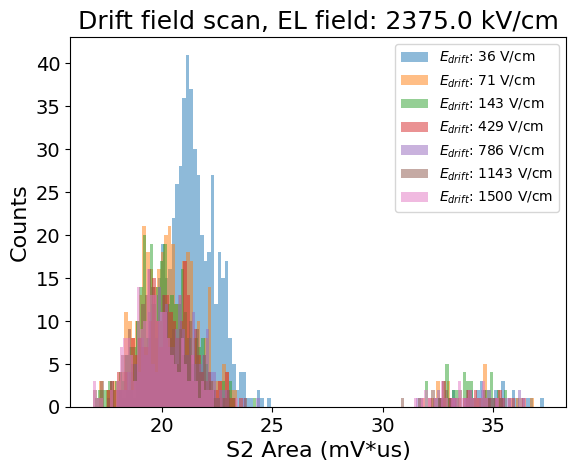

In [190]:
analyzer.plot_histograms()

50 V: amplitude=36.88, mean=21.23, sigma=1.14)
50 V: amplitude=1.50, mean=34.99, sigma=1.22)
100 V: amplitude=22.32, mean=20.20, sigma=1.34)
100 V: amplitude=1.52, mean=33.79, sigma=1.45)
200 V: amplitude=19.03, mean=20.02, sigma=1.19)
200 V: amplitude=2.74, mean=33.94, sigma=1.34)
600 V: amplitude=14.34, mean=20.30, sigma=1.28)
600 V: amplitude=1.11, mean=34.25, sigma=1.63)
1100 V: amplitude=12.09, mean=20.47, sigma=1.29)
1100 V: amplitude=1.09, mean=35.03, sigma=2.28)
1600 V: amplitude=13.66, mean=19.87, sigma=1.28)
1600 V: amplitude=1.50, mean=33.83, sigma=1.33)
2100 V: amplitude=14.26, mean=19.59, sigma=1.05)
2100 V: amplitude=1.74, mean=33.58, sigma=1.29)


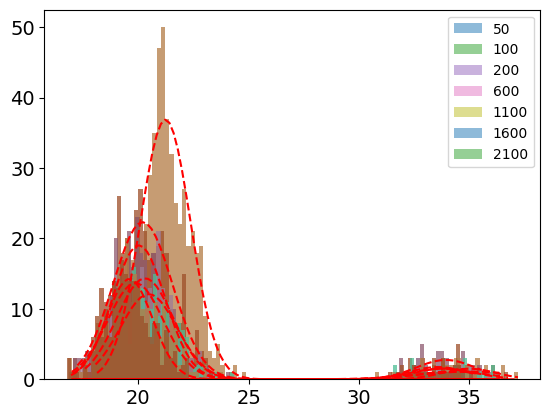

In [192]:
analyzer.fit_histograms_2peaks(sep_A=25);

array([<Axes: title={'center': 'Mean S2 Area vs $E_{drift}$ (95% CI)'}, xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\\cdot$us)'>,
       <Axes: title={'center': 'Mean S2 Area vs $E_{drift}$ (95% CI)'}, xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\\cdot$us)'>],
      dtype=object)

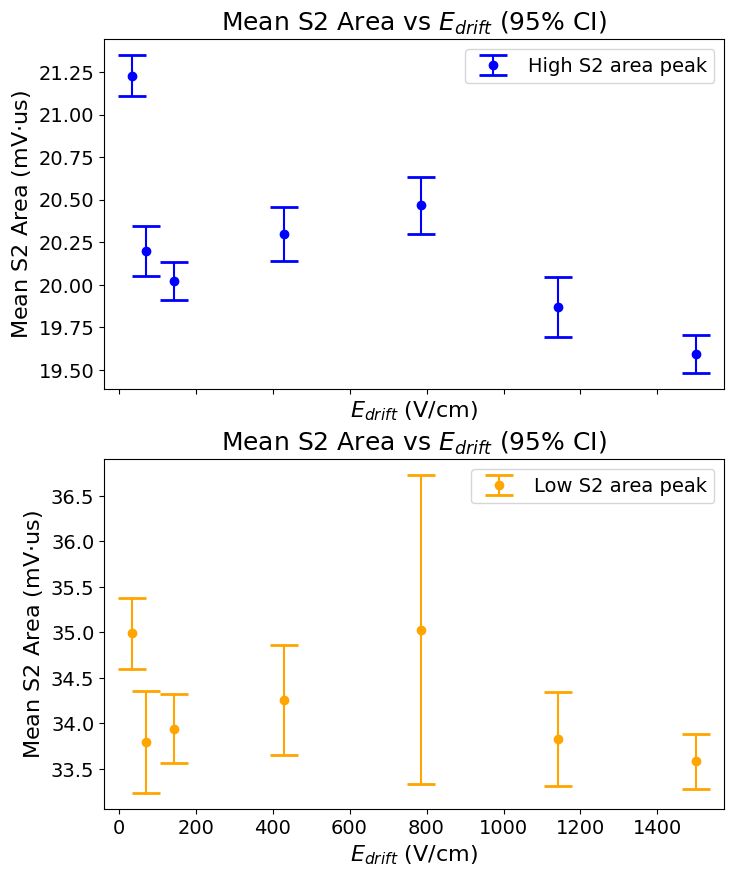

In [193]:
analyzer.plot_s2_vs_field()

In [202]:
alphas_stopping_range = 8e3 # eV/um
alphas_energy = 5.5e6  # eV
length_EL = 8e3 # um
recoils_energy = 100 # keV
alphas_energy / alphas_stopping_range 
# ionization_density

687.5

# Plot average wf over 1000 wf for all drift fields

In [222]:
subdirs = sorted(glob(base_dir+'/FieldScan*'))
subdirs

['/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3000V_Gate1100V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3500V_Gate1600V',
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V']

/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3000V_Gate1100V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3500V_Gate1600V
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V


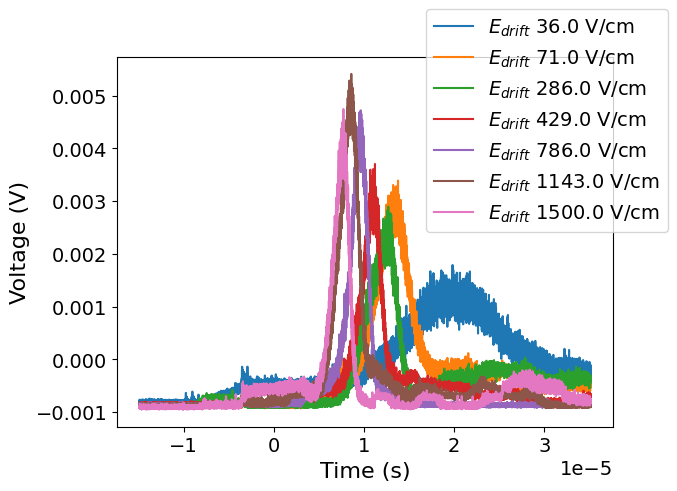

In [235]:
batch_size = 1000
for subd in subdirs:
    print(subd)
    volt_p = extract_voltage_pairs(subd, pattern='FieldScan_5GSsec_Anode{}_Gate{}')
    files = sorted(glob(subd+'/*.wfm'))
    v_avg, t_avg = compute_average_waveform(files[:batch_size], bs_t_window=(-1.5e-5, -1.0e-5), threshold_bs=0.05)
    field = round(volt_p[0,1] / 1.4 , 0) # V/cm
    plt.plot(t_avg, v_avg, label=f'$E_{{drift}}$ {field} V/cm')

plt.gca().set(xlabel='Time (s)', ylabel='Voltage (V)')
plt.gcf().legend()

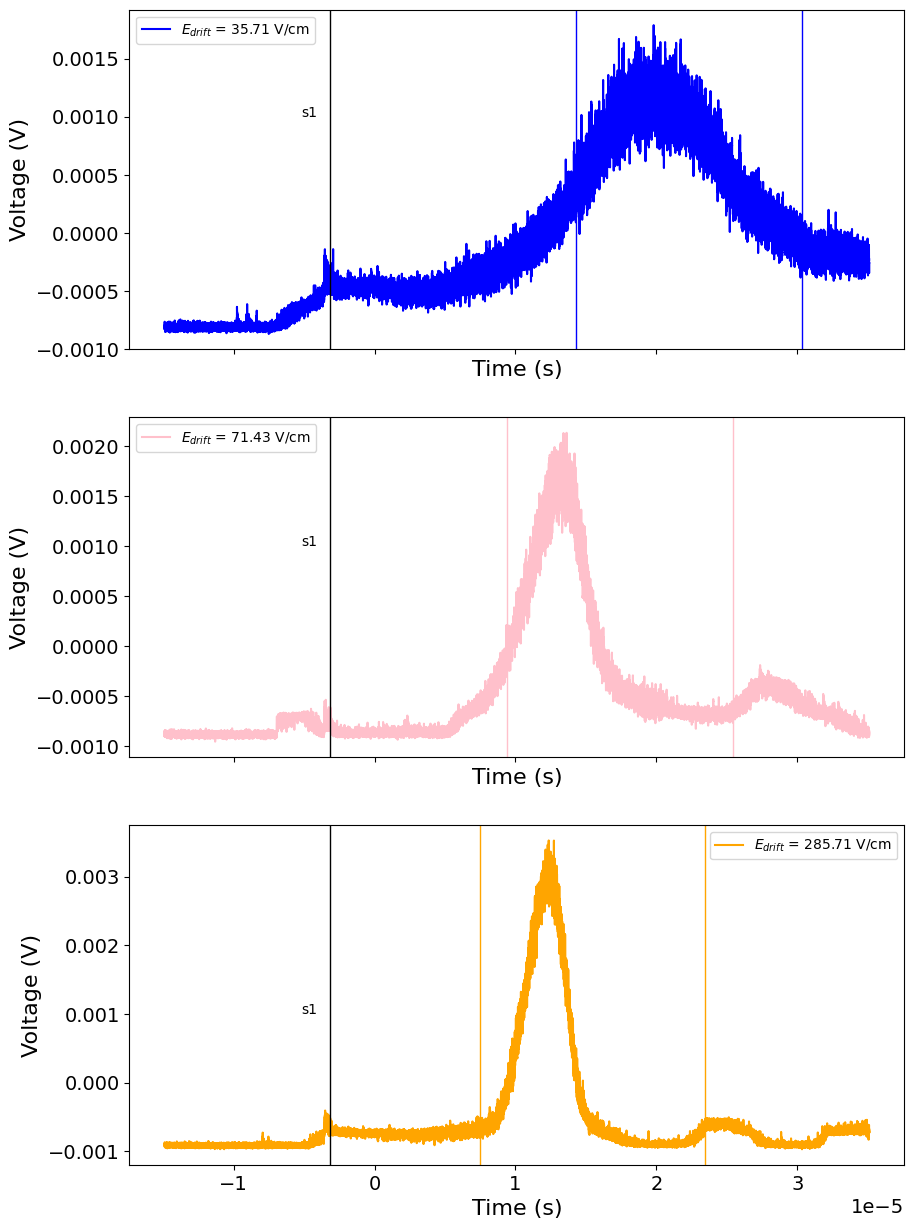

In [268]:
batch_size = 1000
i = 4

s1_jitter = 0.05 # μs
s2_tol_start = 2.5 # μs

s2_duration = 16
s2_tol_end = 2.5 # μs
s2_tol_end = 10e-6

cols = ['blue', 'pink', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
fig, ax = plt.subplots(3, figsize=(10, 15), sharex=True)
for i, subd in enumerate(subdirs[:3]):
    drift_window = (win.s1_avg * 1e6 + s1_jitter, win.s1_avg *1e6 - s1_jitter + drift_times[i] - s2_tol_start)
    s2_window = (drift_window[1], drift_window[1] + s2_duration + s2_tol_end)
    # print(subd)
    volt_p = extract_voltage_pairs(subd, pattern='FieldScan_5GSsec_Anode{}_Gate{}')
    files = sorted(glob(subd+'/*.wfm'))
    v_avg, t_avg = compute_average_waveform(files[batch_size * i : batch_size * (i + 1)], bs_t_window=(-1.5e-5, -1.0e-5), threshold_bs=0.05)
    field = round(volt_p[0,1] / 1.4, 2)  # V/cm
    col = ax[i].plot(t_avg, v_avg, color=cols[i], label=f'$E_{{drift}}$ = {field} V/cm')[0].get_color()
    ax[i].axvline(drift_window[1]*1e-6, color=col, lw=1)
    ax[i].axvline(s2_window[1]*1e-6, color=col, lw=1)

    ax[i].axvline(win.s1_avg, color='k', lw=1)
    ax[i].text(s='s1', x=win.s1_avg - 2e-6, y=0.001, color='k')
    ax[i].set(xlabel='Time (s)', ylabel='Voltage (V)')
    ax[i].legend(fontsize=10)
    # plt.show()


In [ ]:

density = 0.012 # g/cm3 at 2.0 bar

stopping_power =   # MeV*cm2/g
range_alpha = alphas_energy / (stopping_power * density)  # cm
range_alpha  # cm
1.5 # cm, stopping range, projected range should be about 1/3 of this

# Move out ch4 files

In [ ]:
pathch4 = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode4000V_Gate2100V/*Ch4.wfm'
filesch4 = sorted(glob(pathch4))
filesch4
# pathout = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/data_source_ch4/Ch4_FieldScan_5GSsec_Anode4000V_Gate2100V'
# for f in filesch4:
#     !mv {f} {pathout}

[]